# ApRES data quality control 
Use this notebook to quality control data collected during the deployment of ApRES units. 

As described in the [checklist](https://docs.google.com/document/d/1szAn3jsHMNxfMRui8-35VI7EjeVs8Lp5sB5TTNECf4c/edit), a short series of unattended measurements should be made using attenuator and gain settings selected by performing trial bursts. This notebook can then be used to load and examine those data. This will inform any changes needed to the survey (e.g, changing gain or attenuator settings, or the number of sub-bursts), or confirm that the selected settings are, to our best estimate, the most appropriate to be used.  




If needed, a conda environment can be created using the provided environment.yml file. Type the following in the terminal:

```
conda env create -f environment.yml
```

## Load the XApRES package

In [123]:
import xapres as xa
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np


## Point the code to the data
Change the path in the cell below to be path to the folder containing the dat files colleted during the short unattended survey. 

In [52]:
directory = "../../data/apres-test-ldeo-may31-2024/data/DIR2024-05-31-1932"  

## Load the data

In [53]:
unattended_data = xa.load.generate_xarray(directory=directory)
unattended_data

<xarray.Dataset> Size: 24MB
Dimensions:          (time: 10, chirp_time: 40001, chirp_num: 2,
                      attenuator_setting_pair: 2, profile_range: 16644)
Coordinates:
  * time             (time) datetime64[ns] 80B 2024-05-31T19:32:55 ... 2024-0...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * profile_range    (profile_range) float64 133kB 0.0 0.2103 ... 3.5e+03
  * chirp_num        (chirp_num) int64 16B 0 1
    filename         (time) <U85 3kB '../../data/apres-test-ldeo-may31-2024/d...
    burst_number     (time) int64 80B 0 1 2 3 4 5 6 7 8 9
    AFGain           (attenuator_setting_pair) int64 16B -14 -4
    attenuator       (attenuator_setting_pair) float64 16B 6.0 10.0
    orientation      (time) <U7 280B 'unknown' 'unknown' ... 'unknown' 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 13MB ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 11MB ...
    latitude         (time) float64 80B 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    longitude        (time) float64 80B 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    battery_voltage  (time) float64 80B 12.4 12.41 12.41 ... 12.42 12.42 12.42
    temperature_1    (time) float64 80B 32.43 31.84 34.78 ... 28.9 30.47 28.9
    temperature_2    (time) float64 80B 32.98 33.77 32.2 ... 33.18 34.36 33.57

# Simple checks

### Check that time of the first and last measurements match your notes from the field

In [54]:
print(f" time of first measurement: {unattended_data.time.isel(time=0).values}")
print(f" time of last measurement: {unattended_data.time.isel(time=-1).values}")

 time of first measurement: 2024-05-31T19:32:55.000000000
 time of last measurement: 2024-05-31T19:37:17.000000000


### Check the interval between measurements
this should be equal to the value of RepSecs (assuming IntervalMode=0)

In [55]:
print((unattended_data.time.values[1:] - unattended_data.time.values[:-1])/1e9) # the /1e9 is because the time is in nanoseconds

[22 30 30 30 30 30 30 30 30]


### Check the battery voltage didnt change dramatically

In [56]:
print(unattended_data.battery_voltage.values)
# unattended_data.battery_voltage.plot()  # or you can plot it by uncommenting this line

[12.3992 12.4072 12.4113 12.4153 12.4153 12.4113 12.4153 12.4153 12.4153
 12.4153]


## Check the actual data
### plot a single chirp

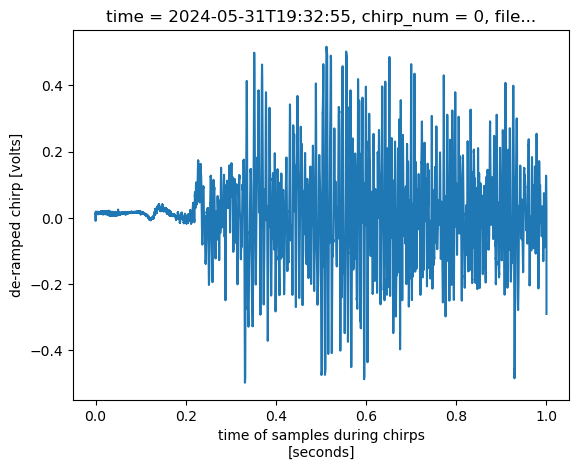

In [57]:
unattended_data.isel(time=0, attenuator_setting_pair =0, chirp_num = 0).chirp.plot()  # plot the first chirp

The example data here looks little strange because this was just testing at Lamont and the antennas were not constructed fully. Your chirps should look like the right-hind 75% of the the plot above everywheer (i.e. the left-most 25% is not what it should look like).

### Look for clipping
By plotting all the chirp samples for all the burst for a given attenuator setting pair

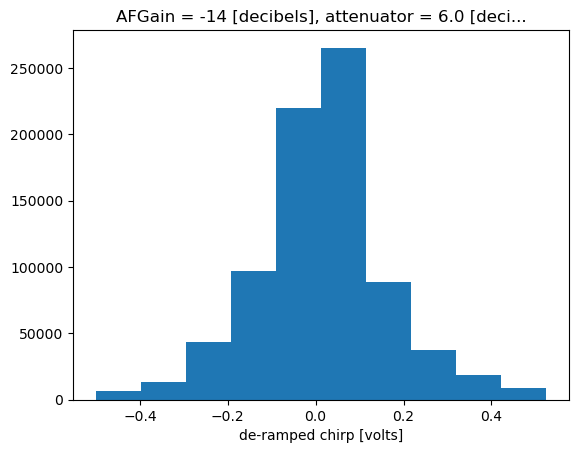

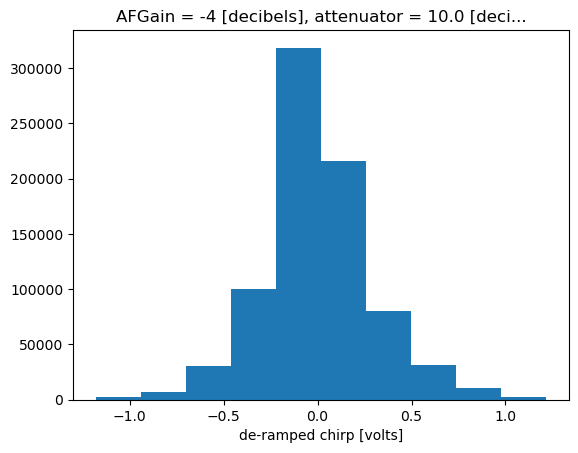

In [75]:
for a in unattended_data.attenuator_setting_pair.values:
    unattended_data.chirp.isel(attenuator_setting_pair = a).plot()  # plot all chirps
    plt.show()


### Plot a profile 
To see if you data has a reasonable noise floor and you can see the bed.

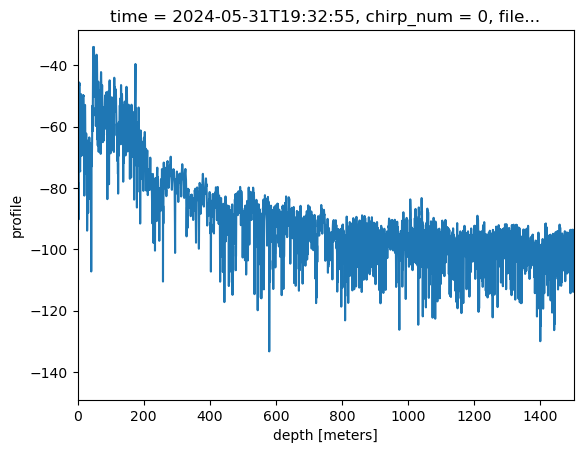

In [80]:
unattended_data.isel(time=0, attenuator_setting_pair =0, chirp_num = 0).profile.dB().plot(xlim = (0, 1500))  

Note that the example data here is not collected over ice, so you cant see the data here. 
Below is a plot of a profile taken over greenland that will probably resemble your sata from Flask more closely. 

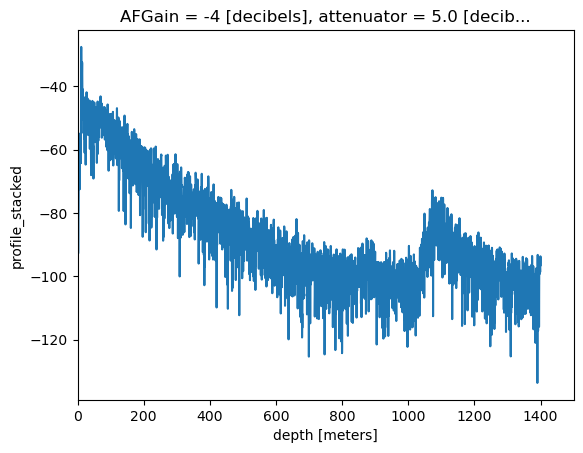

In [132]:
greenland_data = xa.load.load_zarr()
greenland_data.isel(time=2000, attenuator_setting_pair =0).profile_stacked.dB().plot(xlim = (0, 1500))
plt.savefig('greenland_profile_1.png')

The cell above will not run if you dont have an internet connection, so it is saved as greenland_profile_1.png in this folder.

There is a good chance that you will see the bed in a similar way to the plot above in the Flask data. 

## Additional ideas for plotting
Below this are additional ideas for plotting the data and looking at the effect of stacking to perhaps estimate whether we need more sub-bursts per measurement. 

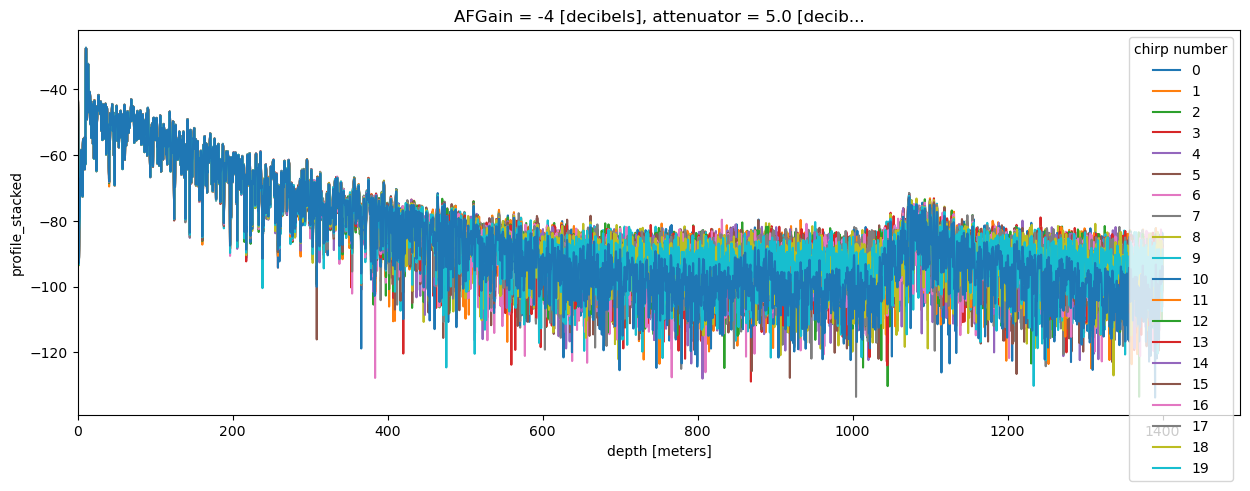

In [133]:
greenland_data.isel(time=2000, attenuator_setting_pair =0).profile.dB().plot(x='profile_range', xlim = (0, 1500), hue = 'chirp_num', figsize = (15, 5));
greenland_data.isel(time=2000, attenuator_setting_pair = 0).profile_stacked.dB().plot();
plt.savefig('greenland_unstacked_and_stacked.png')

If you cannot see this plot becuase it hasnt been saved with the notebook or you dont have an internet connection to run the code it is saved as greenland_unstacked_and_stacked.png

Create an xarray with many stacked profiles, each one using a different number of profiles in the stacking

In [99]:
greenland_data.isel(time=2000, attenuator_setting_pair =0).load()
da_list=[]
for n in greenland_data.chirp_num.values:
    da_list.append(greenland_data.isel(time=2000, attenuator_setting_pair =0, chirp_num = slice(0,n)).profile.mean(dim='chirp_num').dB())

In [129]:
average_over_n_chirps = xr.DataArray(np.arange(0, 20), dims='average_over_n_chirps', name='average_over_n_chirps')
da = xr.concat(da_list, dim = average_over_n_chirps).rename('profile')

<xarray.DataArray 'profile' (average_over_n_chirps: 20, profile_range: 6658)> Size: 1MB
dask.array<concatenate, shape=(20, 6658), dtype=float64, chunksize=(1, 6658), chunktype=numpy.ndarray>
Coordinates:
    AFGain                 int64 8B dask.array<chunksize=(), meta=np.ndarray>
    attenuator             float64 8B dask.array<chunksize=(), meta=np.ndarray>
    burst_number           int64 8B dask.array<chunksize=(), meta=np.ndarray>
    filename               <U83 332B dask.array<chunksize=(), meta=np.ndarray>
  * profile_range          (profile_range) float64 53kB 0.0 0.2103 ... 1.4e+03
    time                   datetime64[ns] 8B 2022-06-16T08:06:44
  * average_over_n_chirps  (average_over_n_chirps) int64 160B 0 1 2 ... 17 18 19

Take a look at the effect of stacking on the noise floor by plotting out three profiels from the xarray we created above. The first profile is just one single profile, the second is created from 9 profiles and the third is created from 19 profiles.

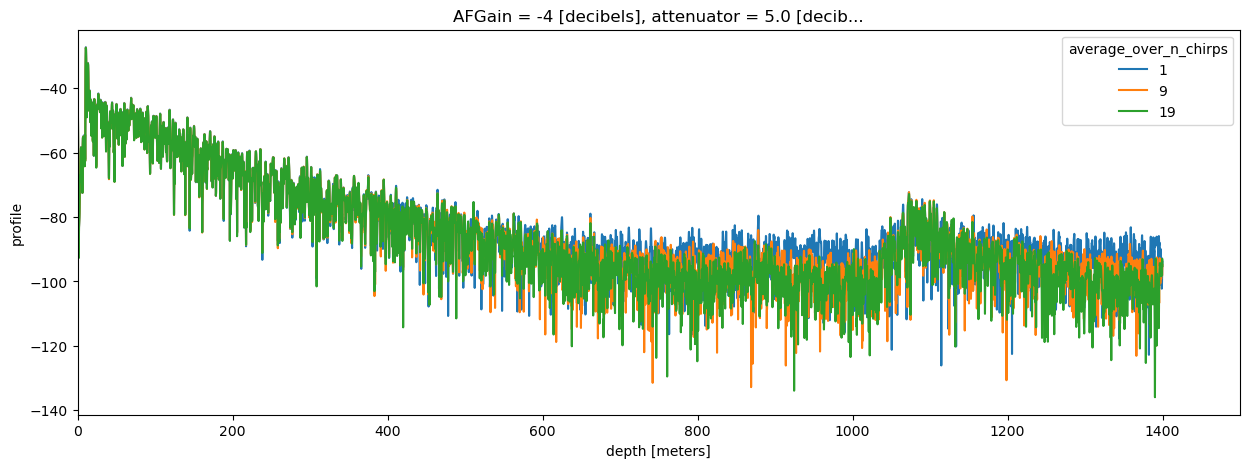

In [134]:
da.isel(average_over_n_chirps =[1, 9, 19]).plot(xlim = (0, 1500), hue = 'average_over_n_chirps', figsize = (15, 5));
plt.savefig('greenland_average_over_n_chirps.png')

This plot is saved as greenland_average_over_n_chirps.png